In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Datos
https://fred.stlouisfed.org/series/S4248SM144NCEN

In [2]:
df = pd.read_csv('./Alcohol_Sales.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'MS'
df.columns = ['Sales']

In [3]:
df.head()

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


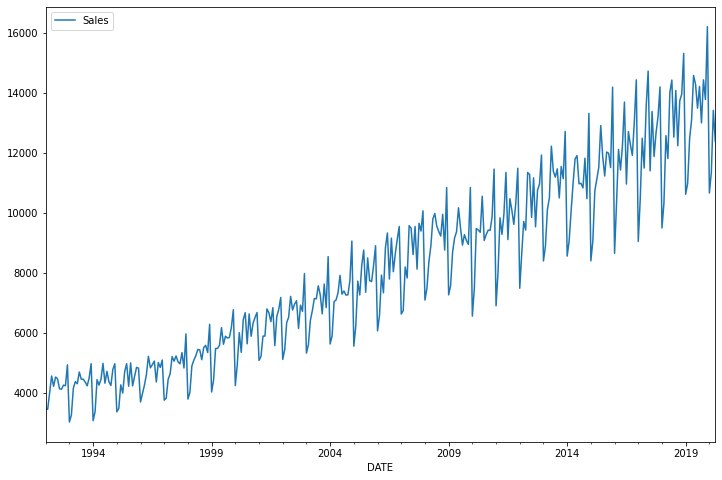

In [4]:
df.plot(figsize=(12,8))

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


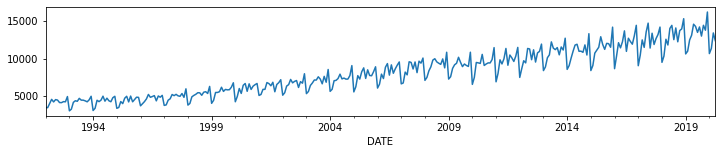

In [6]:
results = seasonal_decompose(df['Sales'])
results.observed.plot(figsize=(12,2))

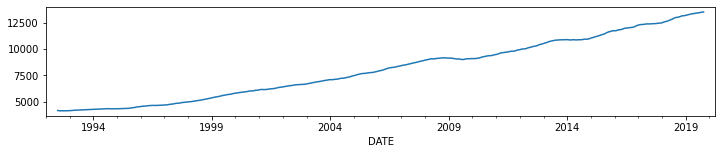

In [7]:
results.trend.plot(figsize=(12,2))

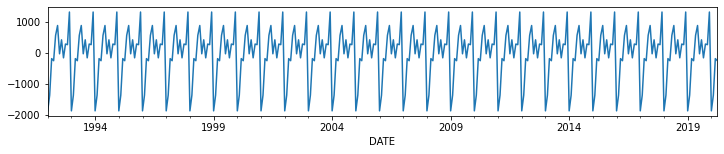

In [8]:
results.seasonal.plot(figsize=(12,2))

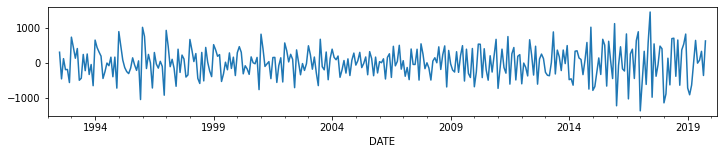

In [9]:
results.resid.plot(figsize=(12,2))

## Train Test Split

In [10]:
len(df)

340

In [11]:
len(df)-12 

328

In [12]:
train = df.iloc[:len(df)-12]
test = df.iloc[len(df)-12:]

In [13]:
len(test)

12

## Escalando los datos

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()

In [16]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [17]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

Este generador toma una secuencia de puntos de datos (como una sereie temporal) espaciados en intervalos iguales, teniendo en cuenta otros parámetros de series temporales, para producir batches para el entrenamiento / validación.

#### Argumentos
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [18]:
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [19]:
scaled_train

array([[0.03486194],
       [0.03478048],
       [0.07909098],
       [0.12486764],
       [0.09692922],
       [0.12201678],
       [0.11688523],
       [0.09008715],
       [0.08919117],
       [0.10002444],
       [0.09847683],
       [0.1551682 ],
       [0.        ],
       [0.01873422],
       [0.09196058],
       [0.1096359 ],
       [0.10393419],
       [0.13561945],
       [0.11623361],
       [0.11615215],
       [0.10857701],
       [0.09815101],
       [0.11965464],
       [0.15826342],
       [0.00358394],
       [0.02818278],
       [0.11501181],
       [0.10018734],
       [0.11639651],
       [0.1591594 ],
       [0.10531889],
       [0.13749287],
       [0.10939155],
       [0.09912845],
       [0.14278733],
       [0.15801906],
       [0.02761261],
       [0.03689827],
       [0.10083897],
       [0.07843936],
       [0.13716706],
       [0.15826342],
       [0.09709212],
       [0.1603812 ],
       [0.09806956],
       [0.12405311],
       [0.14824469],
       [0.146

In [20]:
# Definimos el generator
n_input = 2
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [21]:
len(scaled_train)

328

In [22]:
len(generator) # n_input = 2

326

In [23]:
scaled_train[:5]

array([[0.03486194],
       [0.03478048],
       [0.07909098],
       [0.12486764],
       [0.09692922]])

In [24]:
# ¿Cómo luce el primer batch?
generator[0]

(array([[[0.03486194],
         [0.03478048]]]), array([[0.07909098]]))

In [25]:
X,y = generator[0]

In [26]:
print(f'Datos: \n{X.flatten()}')
print(f'Predicción: \n {y}')

Datos: 
[0.03486194 0.03478048]
Predicción: 
 [[0.07909098]]


In [27]:
# Vamos a redefinir para que utilice 12 meses y luego prediga el próximo mes
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [28]:
# ¿Cómo luce el primer batch?
X,y = generator[0]

In [29]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.03486194 0.03478048 0.07909098 0.12486764 0.09692922 0.12201678
 0.11688523 0.09008715 0.08919117 0.10002444 0.09847683 0.1551682 ]
Predict this y: 
 [[0.]]


### Creando el Modelo

In [30]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [31]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [33]:
# fit model
model.fit_generator(generator,epochs=50)

Epoch 1/50
316/316 [==============================] - 2s 7ms/step - loss: 0.0138
Epoch 2/50
316/316 [==============================] - 2s 6ms/step - loss: 0.0109
Epoch 3/50
316/316 [==============================] - 2s 6ms/step - loss: 0.0081
Epoch 4/50
316/316 [==============================] - 2s 6ms/step - loss: 0.0084
Epoch 5/50
316/316 [==============================] - 2s 6ms/step - loss: 0.0066
Epoch 6/50
316/316 [==============================] - 2s 6ms/step - loss: 0.0054
Epoch 7/50
316/316 [==============================] - 2s 6ms/step - loss: 0.0041
Epoch 8/50
316/316 [==============================] - 2s 6ms/step - loss: 0.0034
Epoch 9/50
316/316 [==============================] - 2s 6ms/step - loss: 0.0028
Epoch 10/50
316/316 [==============================] - 2s 6ms/step - loss: 0.0024
Epoch 11/50
316/316 [==============================] - 2s 6ms/step - loss: 0.0024
Epoch 12/50
316/316 [==============================] - 2s 6ms/step - loss: 0.0019
Epoch 13/50
316/316 [====

In [34]:
model.history.history.keys()

dict_keys(['loss'])

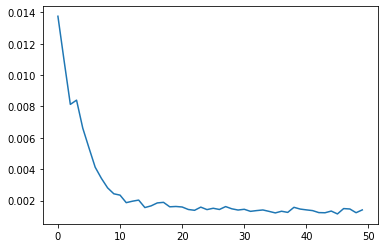

In [35]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

## Evaluando en los Datos de Prueba (Test)

In [36]:
# 12 meses de historia ---> predecir el 13
# Necesitaremos los últimos 12 meses del conjunto de entrenamiento para predecir el 1er mes en el conjunto de prueba
first_eval_batch = scaled_train[-12:]

In [37]:
first_eval_batch

array([[0.89443675],
       [0.92766963],
       [0.77274578],
       [0.89940539],
       [0.74936874],
       [0.87122261],
       [0.8893052 ],
       [1.        ],
       [0.61782194],
       [0.64714507],
       [0.76899894],
       [0.8199886 ]])

In [38]:
X.shape

(1, 12, 1)

In [57]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [58]:
first_eval_batch.shape

(1, 12, 1)

In [59]:
model.predict(first_eval_batch)

array([[0.9194121]], dtype=float32)

In [60]:
scaled_test

array([[0.94013195],
       [0.91602183],
       [0.8514295 ],
       [0.9101572 ],
       [0.81135457],
       [0.9282398 ],
       [0.87496946],
       [1.07241183],
       [0.62132443],
       [0.67760854],
       [0.84540197],
       [0.76134235]])

Ahora pongamos esta lógica en un bucle for para predecir el futuro para todo el rango de prueba.
----

In [61]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [62]:
test_predictions

[array([0.9194121], dtype=float32),
 array([0.95415246], dtype=float32),
 array([0.8193053], dtype=float32),
 array([0.93702036], dtype=float32),
 array([0.79334325], dtype=float32),
 array([0.91686565], dtype=float32),
 array([0.9189997], dtype=float32),
 array([1.0383356], dtype=float32),
 array([0.63914555], dtype=float32),
 array([0.70734376], dtype=float32),
 array([0.7986799], dtype=float32),
 array([0.8645813], dtype=float32)]

In [63]:
scaled_test

array([[0.94013195],
       [0.91602183],
       [0.8514295 ],
       [0.9101572 ],
       [0.81135457],
       [0.9282398 ],
       [0.87496946],
       [1.07241183],
       [0.62132443],
       [0.67760854],
       [0.84540197],
       [0.76134235]])

## Transformación inversa y Comparación

In [64]:
true_predictions = scaler.inverse_transform(test_predictions)

In [65]:
true_predictions

array([[14318.62206286],
       [14745.12981117],
       [13089.61117685],
       [14534.7989772 ],
       [12770.87503093],
       [14287.35954624],
       [14313.55897236],
       [15778.64569163],
       [10877.78995556],
       [11715.05930656],
       [12836.39298803],
       [13645.46445936]])

In [67]:
test

,Sales,Predictions
DATE,,
2019-05-01,14573,14318.622063
2019-06-01,14277,14745.129811
2019-07-01,13484,13089.611177
2019-08-01,14205,14534.798977
2019-09-01,12992,12770.875031
2019-10-01,14427,14287.359546
2019-11-01,13773,14313.558972
2019-12-01,16197,15778.645692
2020-01-01,10659,10877.789956


In [ ]:
test['Predictions'] = true_predictions

In [ ]:
test

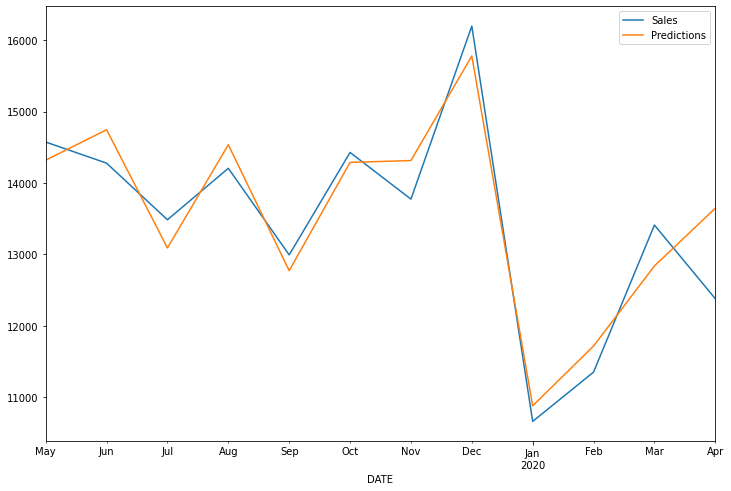

In [68]:
test.plot(figsize=(12,8))

# Guardar un Modelo

In [69]:
model.save('my_rnn_model.h5')

# Cargar un Modelo

In [70]:
from keras.models import load_model
new_model = load_model('my_rnn_model.h5')

In [71]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
